# Dropout Visualization for 2D Convolution Layers

MNIST data set is used to visualize the effects of different dropout types on a model with the form:

    input -> 2D convolution layer -> dropout

In [1]:
import keras
import matplotlib.pyplot as plt
import numpy as np
import warnings

from keras import layers
from keras.models import Model

%matplotlib inline

keras_version = keras.__version__
tf_version = keras.backend.tensorflow_backend.tf.VERSION

print("keras version:", keras_version)
print(keras.backend.backend(), "version:", tf_version)

Using TensorFlow backend.


keras version: 2.2.2
tensorflow version: 1.10.0


#### Load MNIST Data Set

In [2]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

#### Plotting Functions

In [3]:
def plot_output(examples, color_zeroes=False, title=None):
    """Visualize each channel in an image or output from 
    a Keras `Conv2D` layer. Intended for graphing mnist digits and 
    their resulting outputs from Keras layers, but probably will 
    work for other examples. 
    
    # Arguments
        examples: numpy array with shape (batch, height, width, channels) 
        color_zeroes: if true, zero values are colored maroon
        title: optional plot title string
    """
   
    num_channels = examples.shape[-1]
    num_examples = examples.shape[0]    
    
    plt.rcParams['figure.figsize'] = (num_examples, num_channels)
    plt.rcParams['image.interpolation'] = 'nearest'
    plt.rcParams['image.cmap'] = 'gray'
    plt.get_cmap().set_bad('maroon') # color nan
    
    for c in range(num_channels):
        for i, ex in enumerate(examples):
            plt.subplot(num_channels, num_examples, num_examples * c + i + 1)
            if color_zeroes:
                ex[ex==0] = np.nan # set zero values to nan
            plt.imshow(ex[:,:,c])
            plt.axis('off')
            if c == 0 and i == 0 and title is not None:
                # only way I found to keep title placement 
                # semi-consistent for different channel counts
                plt.text(
                    x=0,
                    y=-ex.shape[1] // 4,
                    s=title,
                    fontsize=13,
                    horizontalalignment='left', 
                    verticalalignment='bottom')
            if i == 0:
                plt.text(
                    x=-ex.shape[0] // 2, 
                    y=ex.shape[1] // 2, 
                    s='Channel ' + str(c + 1), 
                    alpha=(num_channels != 1),
                    horizontalalignment='right',
                    verticalalignment='center') 

    with warnings.catch_warnings():
        # supress Warning: converting a masked element to nan.
        warnings.simplefilter("ignore") 
        plt.show()
        

def plot_dropout(examples, dropout_layers, filters=3, show_before_dropout=True):
    """Visualize images and their layer outputs from a Keras 
    model with the form `input -> 2D convolution layer -> dropout`.
    The dropout layer is cycled through the layers in `dropout_layers`
    so the effects of different dropout types can be visualized. 
    Intended for use with mnist digits, but probably will 
    work for other examples.    
        
    # Arguments
        examples: numpy array with shape (batch, height, width, channels),
            input for the model
        dropout_layers: list of Keras dropout layer instances
        filters: the number of filters in the 2D convolution layer 
        show_before_dropout: include a plot of the output channels 
            before dropout is applied
    """ 
        
    # avoid zeroes so only valid dropped values are colored,
    # guaranteed to work for mnist, double chack other data sets
    examples = examples + 1e-07
        
    plot_output(examples, title='Input Images')
    
    # define model    
    inputs = layers.Input(shape=examples.shape[1:])
    np.random.seed(1) # so filters don't change each time plot_dropout is called
    x = layers.Conv2D(
        filters=filters, 
        kernel_size=5, 
        strides=2, 
        padding='same', 
        activation=None, 
        use_bias=False)(inputs)
    np.random.seed(None)
    
    before_dropout = Model(inputs=inputs, outputs=x).predict(examples)
    if 0 in before_dropout:
        warnings.warn("Zeros before dropout.")
    if show_before_dropout:        
        plot_output(before_dropout, title='Output Channels (before dropout)')
    
    for dropout_layer in dropout_layers:
        # set dropout type
        dropout = dropout_layer(x, training=True) # dropout used during predict
        after_dropout = Model(inputs=inputs, outputs=dropout).predict(examples)
        # visualize dropout
        config = dropout_layer.get_config()
        title = 'Output Channels w/ ' + dropout_layer.__class__.__name__ + \
                '(rate=' + str(config['rate']) + \
                ', noise_shape=' + str(config['noise_shape']) + ')\n' + \
                'Proportion Dropped: ' + str(1 - np.count_nonzero(after_dropout) / np.prod(after_dropout.shape))
        plot_output(after_dropout, color_zeroes=True, title=title)

The `plot_output` function colors in zeroes to represent dropout. 
To avoid zeroes in non-dropped positions, the `plot_dropout` function:
- adds a small value to example pixel values
- doesn't use bias or activation in Conv2D layer

## Visualization

Channel outputs are plotted in 2D and dropped values are colored in. The following dropout types are visualized below:

- [Regular Dropout](https://keras.io/layers/core/#dropout)
- [Spatial 2D Dropout](https://keras.io/layers/core/#spatialdropout2d)
- [Regular Dropout](https://keras.io/layers/core/#dropout) with a `noise_shape` argument

You can think of these as visualizations of dropout on one training batch. 
Colored areas wouldn't contribute to the training of the filter corresponding to the output channel. 
In actual training, dropout would be randomly assigned for each batch.

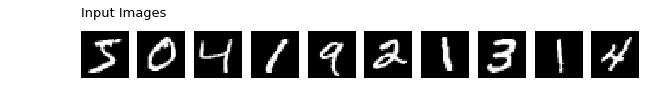

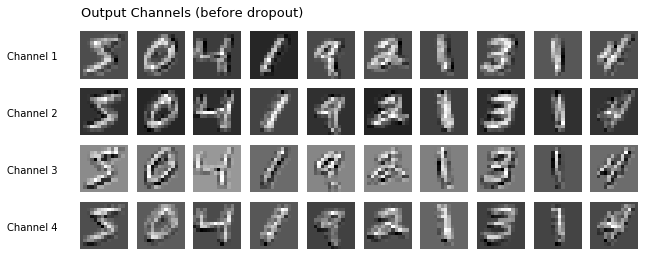

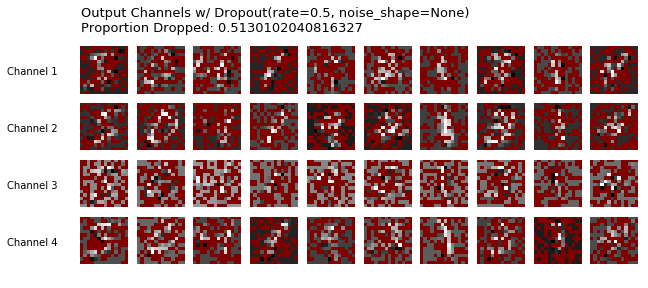

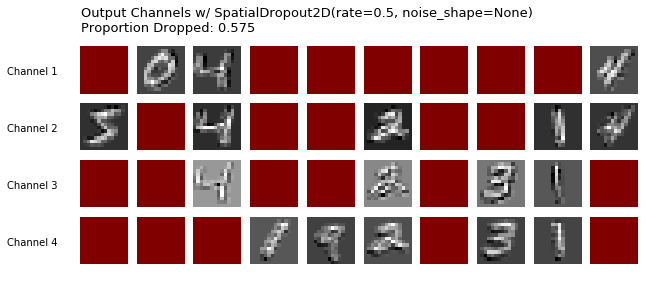

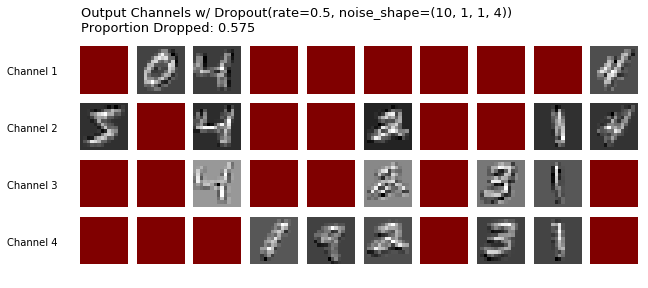

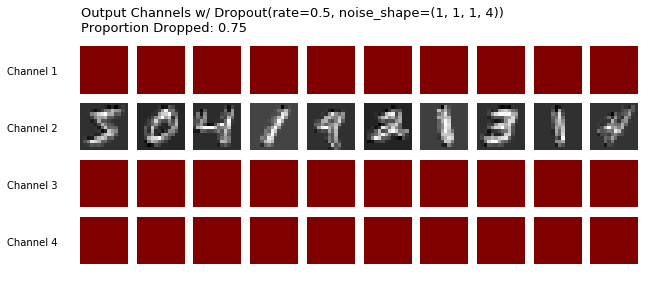

In [4]:
num_examples = 10
num_filters = 4
dropout_rate = 0.5
dropout_seed = 1 # set to None for no seed

examples = np.expand_dims(x_train[:num_examples], -1) # put grayscale channel last

# define the dropout layer types to plot
dropout_layers = [
    layers.Dropout(dropout_rate, seed=dropout_seed), 
    layers.SpatialDropout2D(dropout_rate, seed=dropout_seed), 
    layers.Dropout(dropout_rate, noise_shape=(num_examples,1,1,num_filters), seed=dropout_seed),
    layers.Dropout(dropout_rate, noise_shape=(1,1,1,num_filters), seed=dropout_seed)] 

# the noise shape for the last 2 layers has `num_filters` in the channel position,
# thus the convolutional layer to needs to have `num_filters` filters
plot_dropout(examples, dropout_layers, filters=num_filters) 

Observations:
- the amount dropped is not exactly 50% with `rate=0.5` for any dropout type
- `SpatialDropout2D` has the same result as regular dropout with `noise_shape=(num_examples,1,1,num_filters)`

Below, `SpatialDropout2D` output for three batches of training data is simulated. The seed for dropout is not fixed so each call to `plot_dropout` randomly reassigns dropped values.

batch 1:


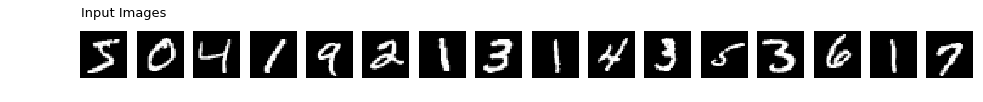

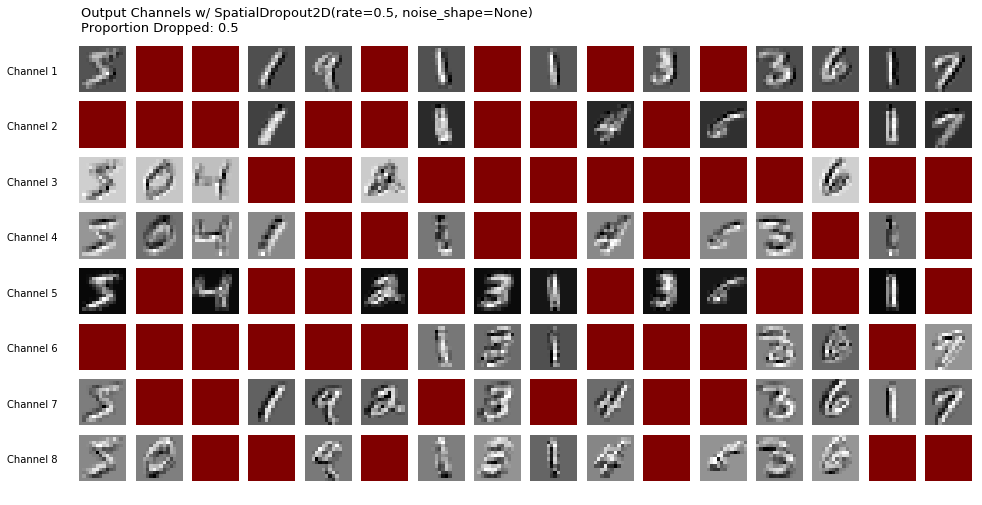

batch 2:


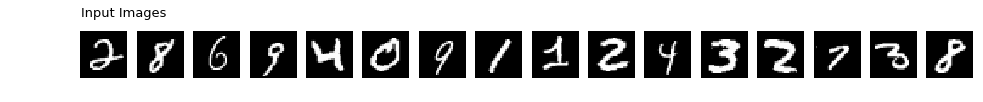

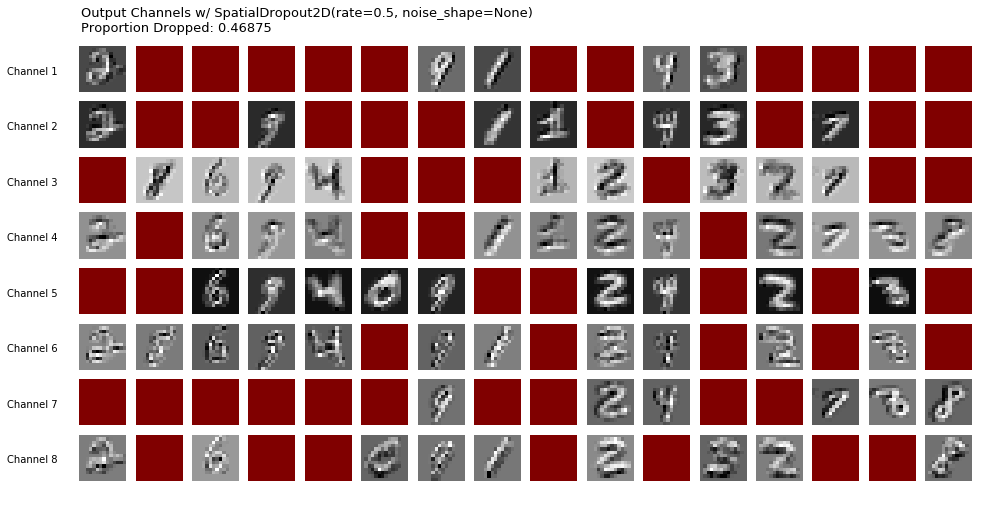

batch 3:


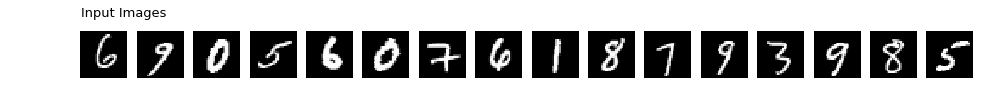

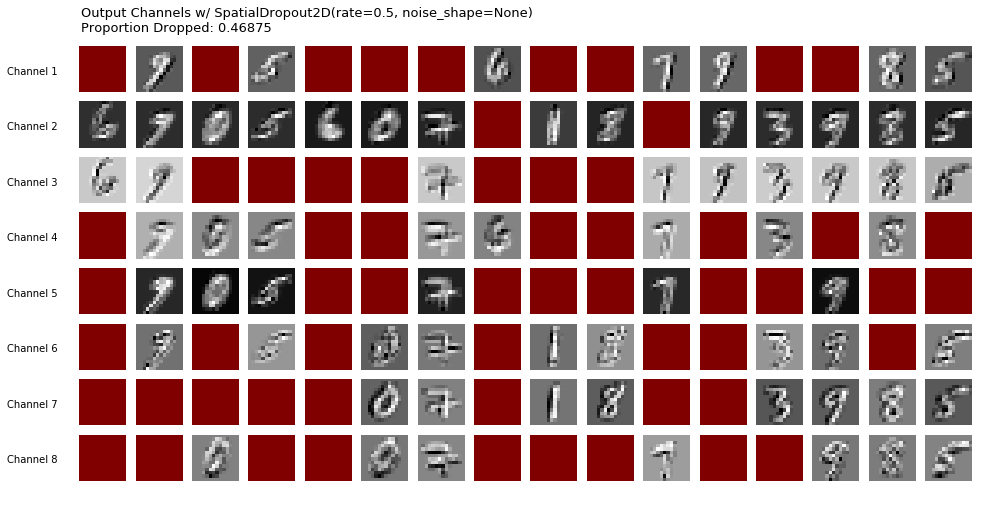

In [5]:
batch_size = 16
num_filters = 8

dropout_layers = [layers.SpatialDropout2D(dropout_rate, seed=None)]

batch_1 = np.expand_dims(x_train[:batch_size], -1)
batch_2 = np.expand_dims(x_train[batch_size:2*batch_size], -1)
batch_3 = np.expand_dims(x_train[2*batch_size:3*batch_size], -1)

print("batch 1:")
plot_dropout(batch_1, dropout_layers, filters=num_filters, show_before_dropout=False) 
print("batch 2:")
plot_dropout(batch_2, dropout_layers, filters=num_filters, show_before_dropout=False)
print("batch 3:")
plot_dropout(batch_3, dropout_layers, filters=num_filters, show_before_dropout=False)